In [1]:
import os

os.chdir("..")

In [2]:
# Import relevant libraries
from commons.quiz import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

In [3]:
# Import the data
file_path: str = "datasets/mall_customers.csv"
data: pd.DataFrame = pd.read_csv(file_path)
data: pd.DataFrame = data.drop("CustomerID", axis=1)

data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [4]:
# A little bit of preprocessing
data["Gender"] = data["Gender"].map({"Male": 0, "Female": 1})

### 2 Dimension

In [5]:
# Specify 2 columns for this topic
data_2d: pd.DataFrame = data[["Annual Income (k$)", "Spending Score (1-100)"]]
data_2d.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


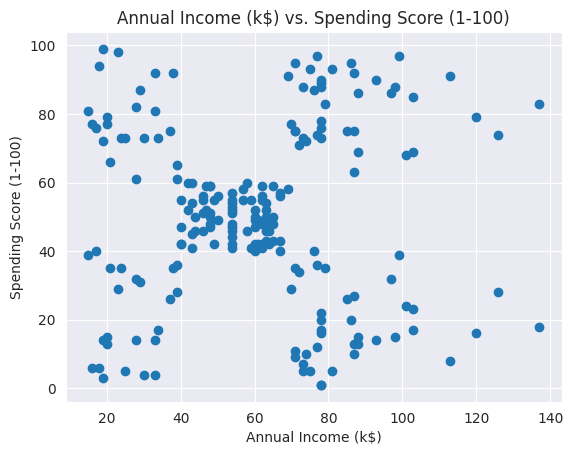

In [6]:
from typing import List, Union

# Let's see the distribution for these features
def plot_scatter(
    x: str, 
    y: str, 
    data: pd.DataFrame,
    **kwargs
) -> None:
    """
    Build a scatter plot

    Parameters
    ----------
        x: str
            name of column contained in data, representing x-axis

        y: str
            name of column contained in data, representing y-axis

        data: pd.DataFrame
            specified data

        colors: Union[List[str], pd.Series]
            list of colors
    """
    plt.scatter(x=data[x], y=data[y], **kwargs)
    plt.title(f"{x} vs. {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

plot_scatter(x="Annual Income (k$)", y="Spending Score (1-100)", data=data_2d)

**Question 1.** From the figure above, do you have any guess how many clusters it should be?

In [7]:
# Give your answer
answer = 5

check_answer_1(answer)

Good job!


Now, let's try to check if the clusters are the same as we expected.

In [8]:
from sklearn.cluster import KMeans

# Make an instance of clustering model: KMeans
kmeans: KMeans = KMeans(n_clusters=answer)

# Resulting the clusters
clusters: np.ndarray = kmeans.fit_predict(X=data_2d[["Annual Income (k$)", "Spending Score (1-100)"]])

# Add column called 'cluster' to `data_2d`
data_2d["cluster"] = clusters

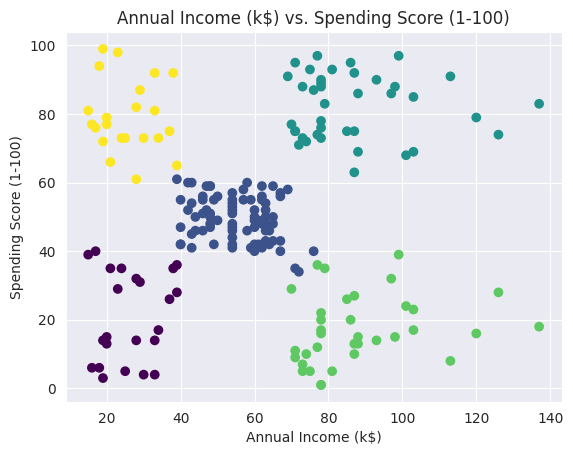

In [9]:
# Let's look at visualization, once again..
plot_scatter(
    x="Annual Income (k$)", 
    y="Spending Score (1-100)", 
    data=data_2d, 
    c=data_2d["cluster"], 
    cmap="viridis"
)

**Perfect!** Let's go back into the original data

In [10]:
# Look at first 5 rows
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


Well, we know that we can only visualize a graph consisting of 3 features, right? Then, we can choose correct number of clusters based on the graph.

However, **for data with higher dimension, how can we choose optimal number of clusters?**

#### Elbow Method (K-Means)

Source: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [11]:
def elbow_method(
    X: pd.DataFrame,
    min_cluster_range: int,
    max_cluster_range: int
) -> None:
    """
    Specify right number of cluster by doing elbow method

    Parameters
    ----------
        X: pd.DataFrame
            specified data

        min_cluster_range: int
            minimum number of probable range of clusters

        max_cluster_range: int
            maximum number of probable range of clusters
    """
    # Within cluster sum of squares
    wcss = []
    for cluster in range(min_cluster_range, max_cluster_range+1):
        kmeans = KMeans(n_clusters=cluster)
        kmeans.fit(X)

        wcss.append(kmeans.inertia_)

    # Plot graph of elbow method
    plt.plot(range(min_cluster_range, max_cluster_range+1), wcss)
    plt.title("Elbow method")
    plt.xlabel("Number of clusters")
    plt.ylabel('WCSS')
    plt.show()

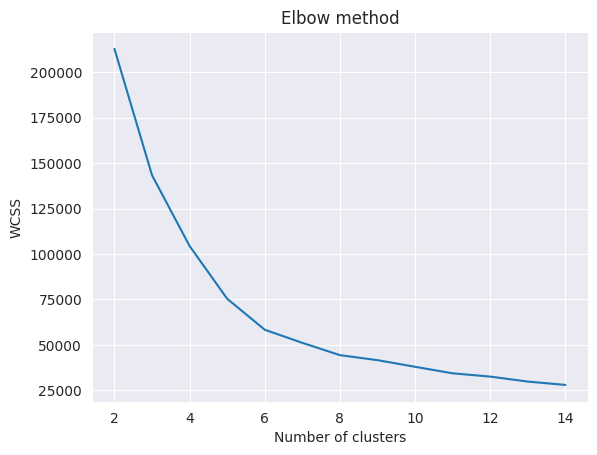

In [12]:
elbow_method(
    X=data,
    min_cluster_range=2,
    max_cluster_range=14
)

#### Silhouette Analysis (All Clustering Models)

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_analysis(
    X: pd.DataFrame,
    col_x: str,
    col_y: str,
    min_cluster_range: int,
    max_cluster_range: int
) -> None:
    """
    Specify right number of cluster by doing silhoutte analysis

    Parameters
    ----------
        X: pd.DataFrame
            specified data

        col_x: str
            column of X, representing x-axis

        col_y: str
            column of X, representing y-axis

        min_cluster_range: int
            minimum number of probable range of clusters

        max_cluster_range: int
            maximum number of probable range of clusters
    """

    range_n_clusters = range(min_cluster_range, max_cluster_range+1)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[col_x], X[col_y], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        columns = X.columns.tolist()
        dim_x = columns.index(col_x)
        dim_y = columns.index(col_y)
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, dim_x],
            centers[:, dim_y],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[dim_x], c[dim_y], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.29307334005502633
For n_clusters = 3 The average silhouette_score is : 0.383798873822341
For n_clusters = 4 The average silhouette_score is : 0.4052954330641215
For n_clusters = 5 The average silhouette_score is : 0.44424291275274114
For n_clusters = 6 The average silhouette_score is : 0.45205475380756527
For n_clusters = 7 The average silhouette_score is : 0.4379584974420345
For n_clusters = 8 The average silhouette_score is : 0.4294098819758089


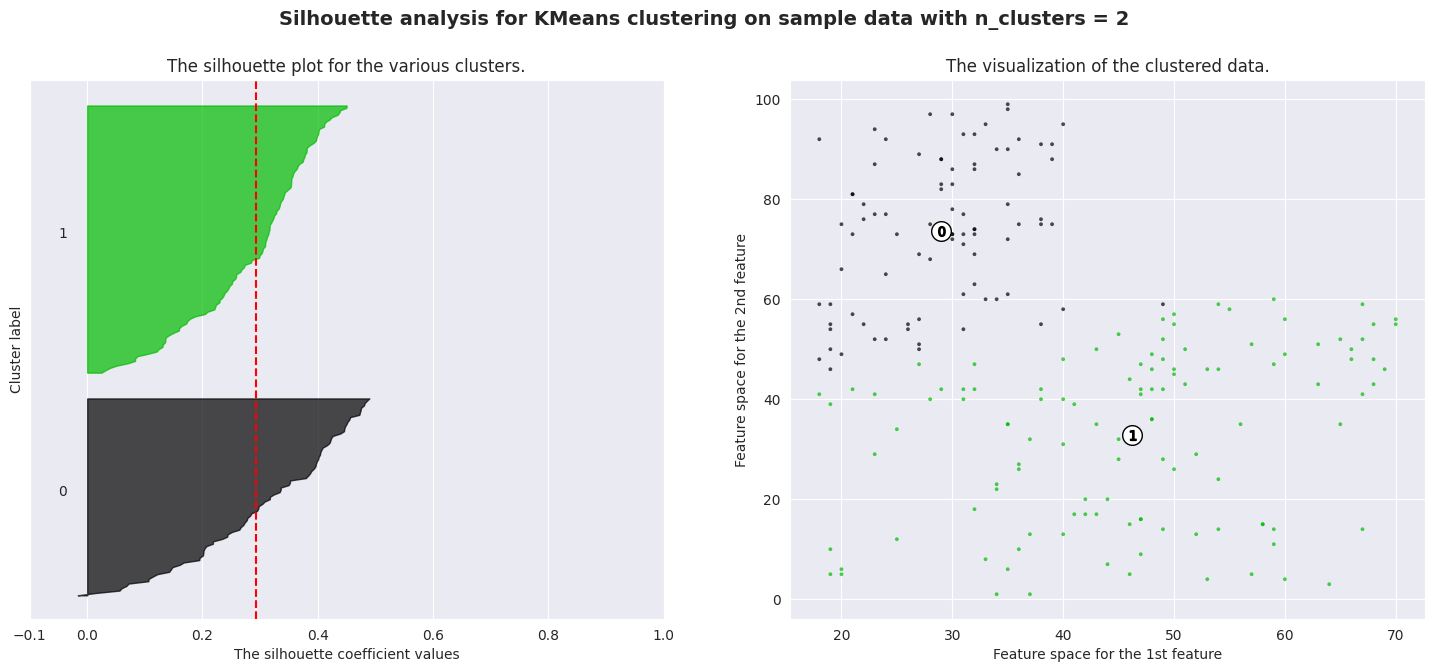

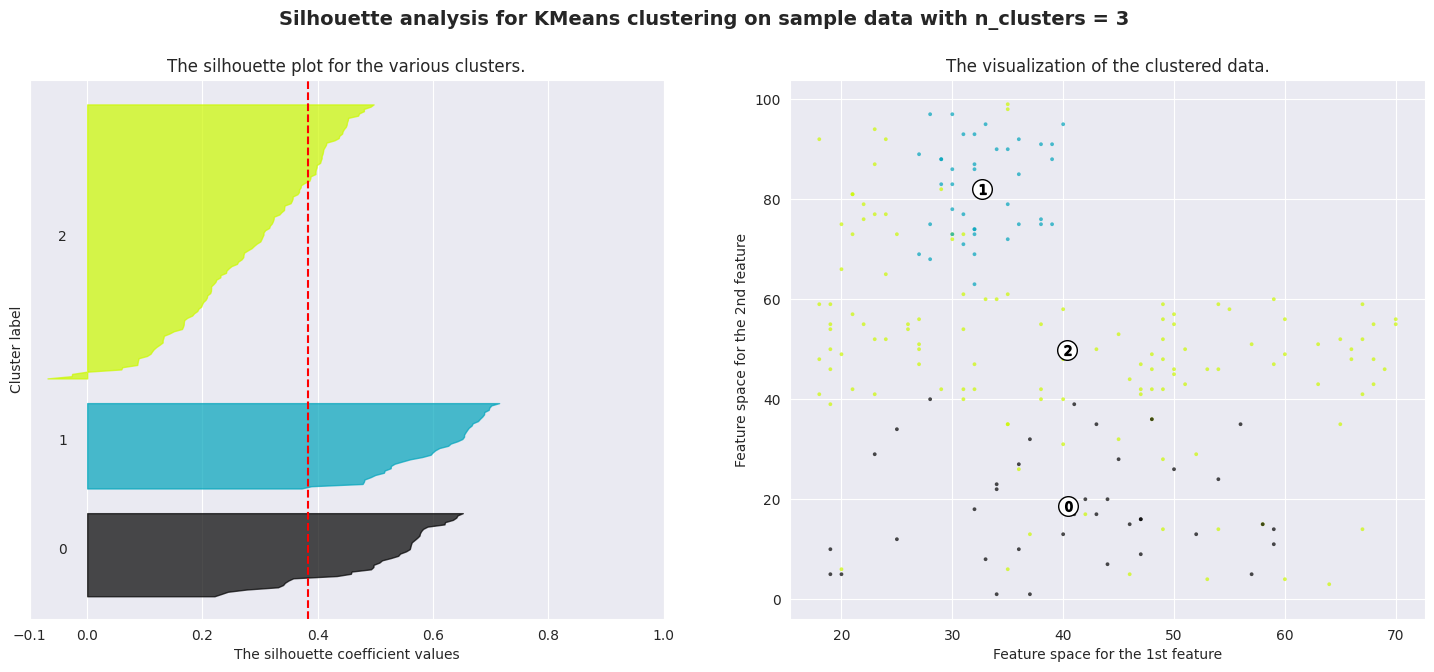

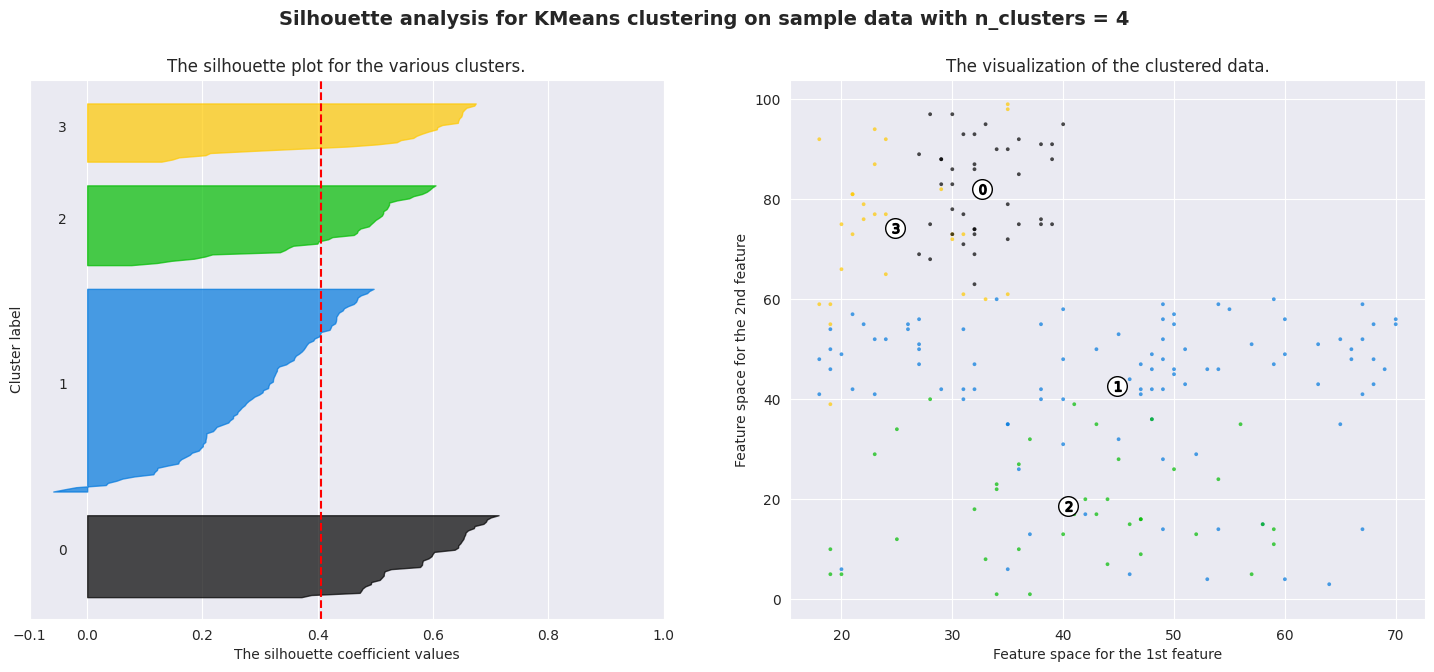

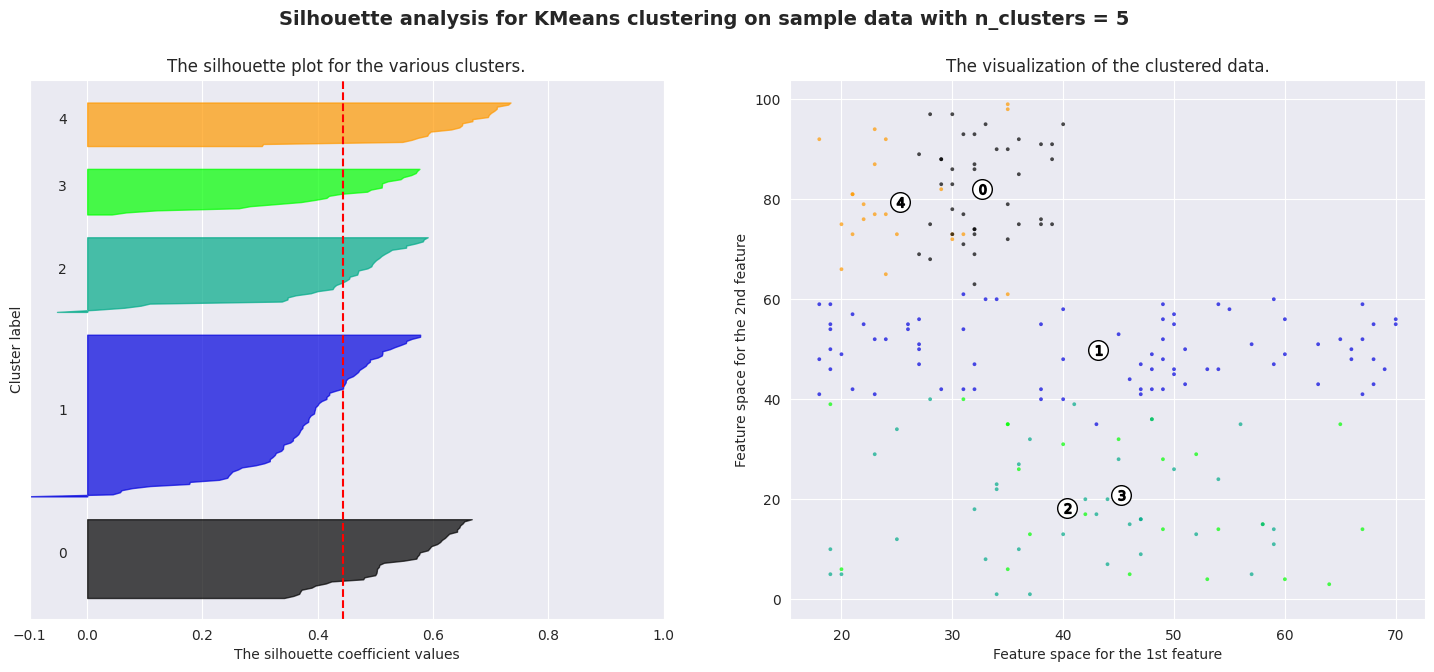

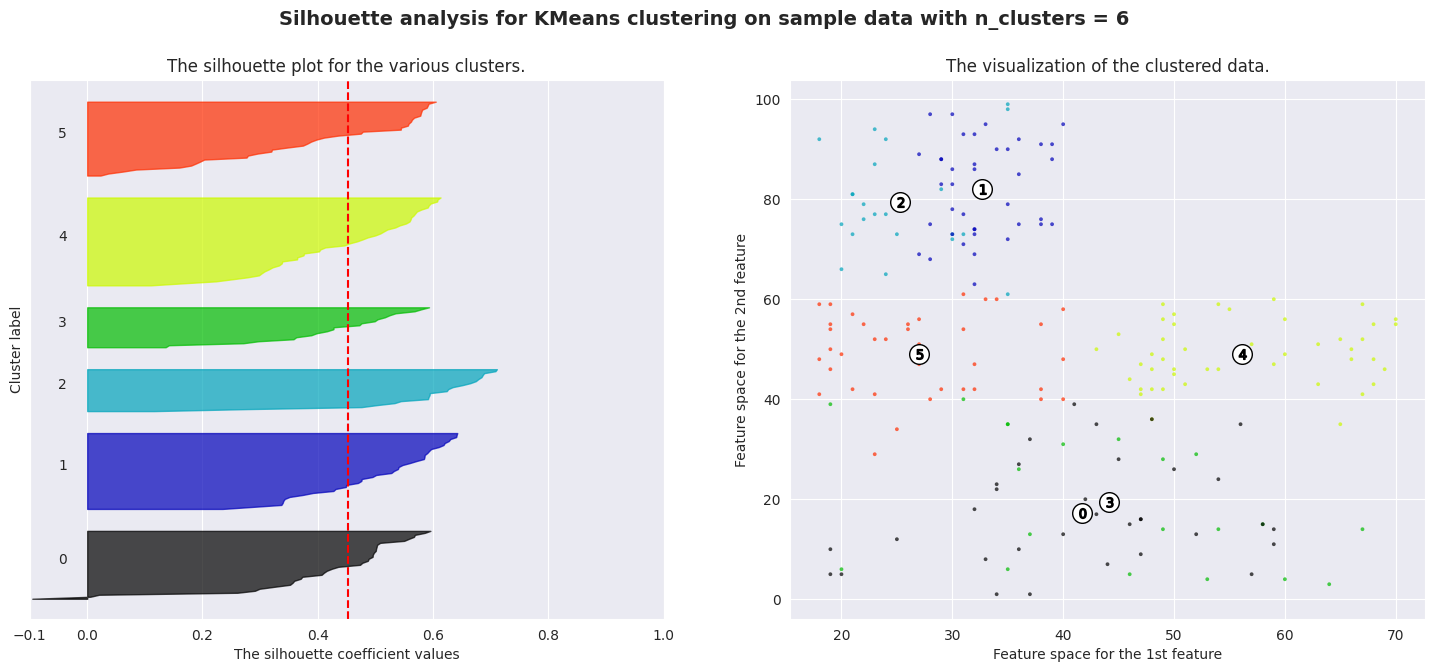

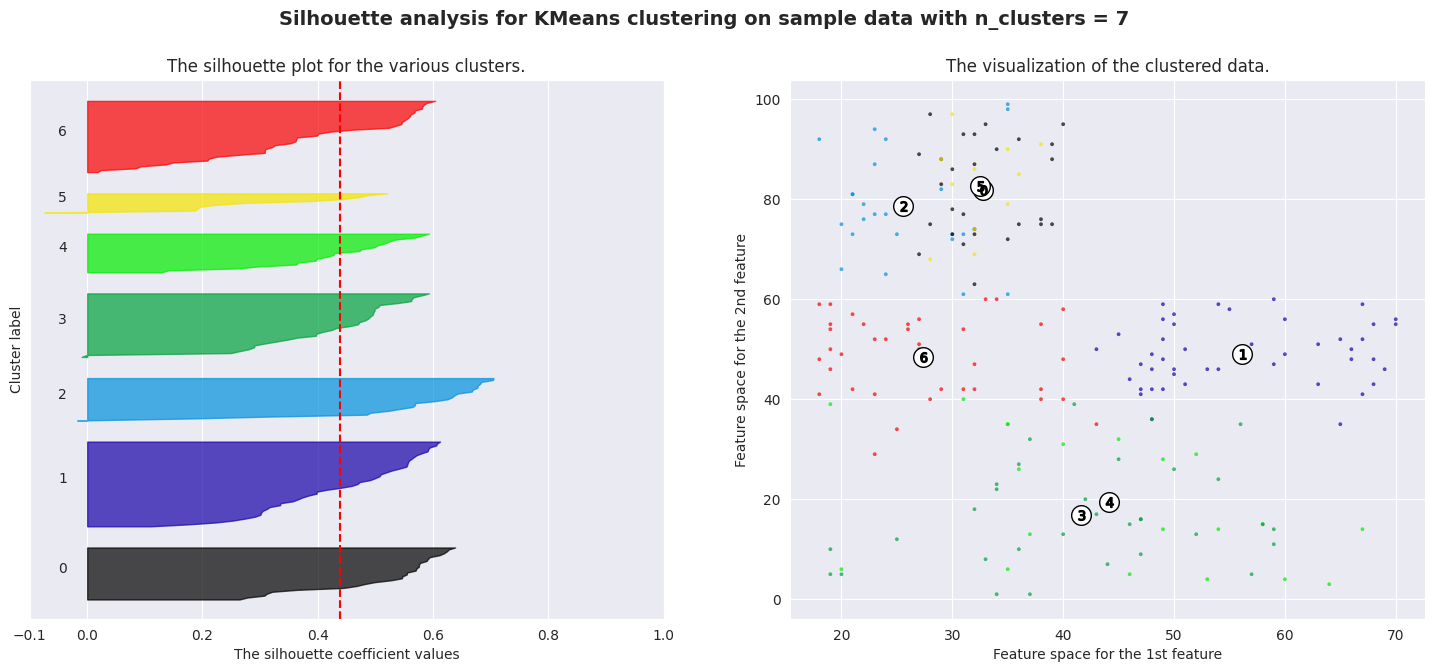

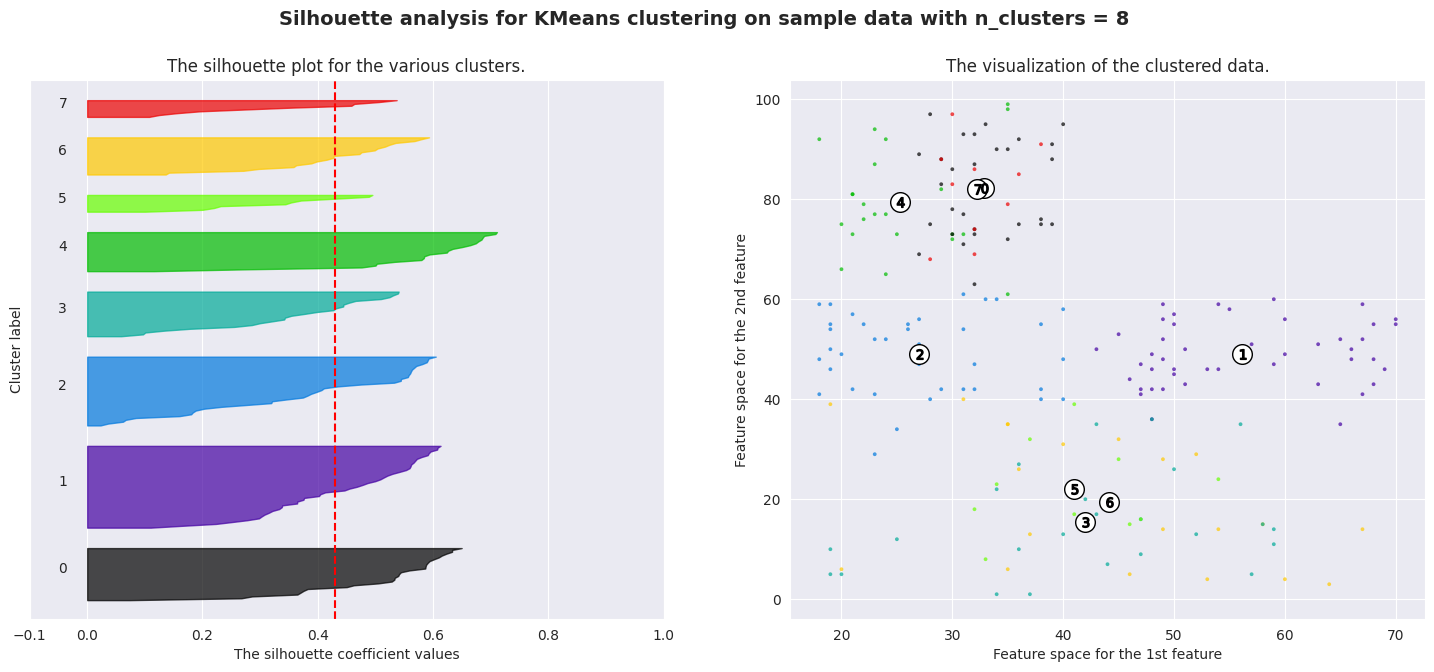

In [14]:
silhouette_analysis(
    X=data,
    col_x="Age",
    col_y="Spending Score (1-100)",
    min_cluster_range=2,
    max_cluster_range=8
)

Okay, I understood all of these, but **can we have other methods so we have intuitive insight from the clustering, especially with higher-dimensional data?**

### Dimensionality Reduction

More or less, the idea is just like below:<br><br>
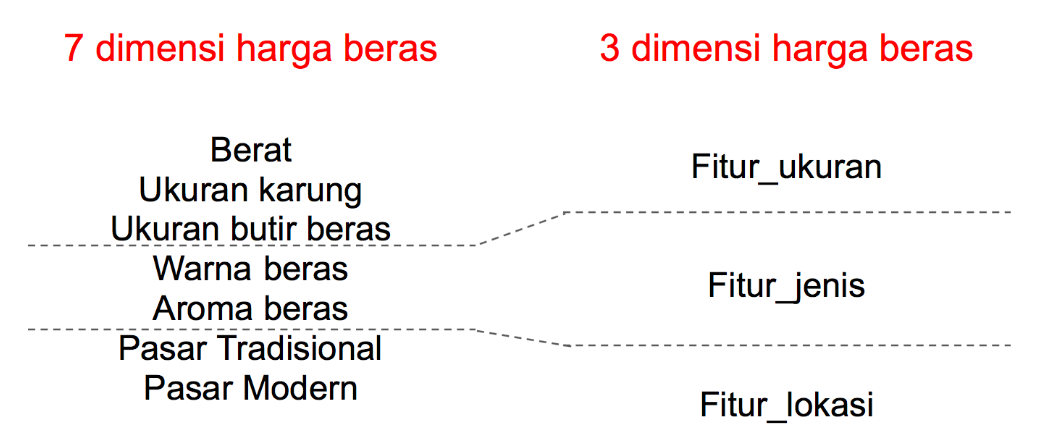

In [15]:
from sklearn.decomposition import PCA

# Make an instance of PCA
pca = PCA(n_components=2)

# Fit-transform using our-own PCA
data_pca = pca.fit_transform(data)

print(f"Before PCA: {data.shape}")
print(f"After PCA: {data_pca.shape}")

Before PCA: (200, 4)
After PCA: (200, 2)


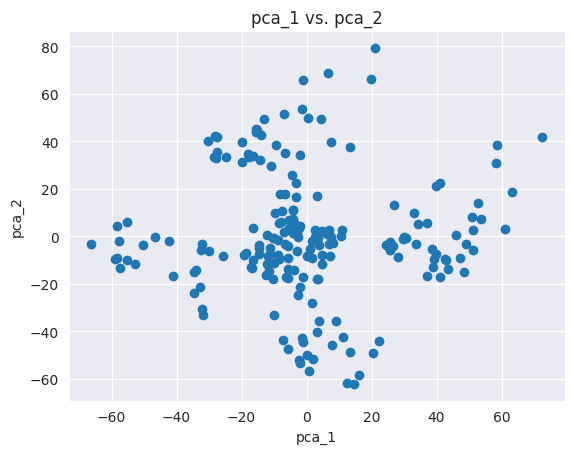

In [16]:
# Let's visualize the data after applying PCA
data_pca_df: pd.DataFrame = pd.DataFrame(data=data_pca, columns=["pca_1", "pca_2"])

plot_scatter(
    x="pca_1",
    y="pca_2",
    data=data_pca_df,
)

**Question 2.** Based on the scatter plot above, what is optimal number of clusters should we choose?

In [17]:
# Answer the question with an integer number
answer = 5

check_answer_2(answer)

Good job!


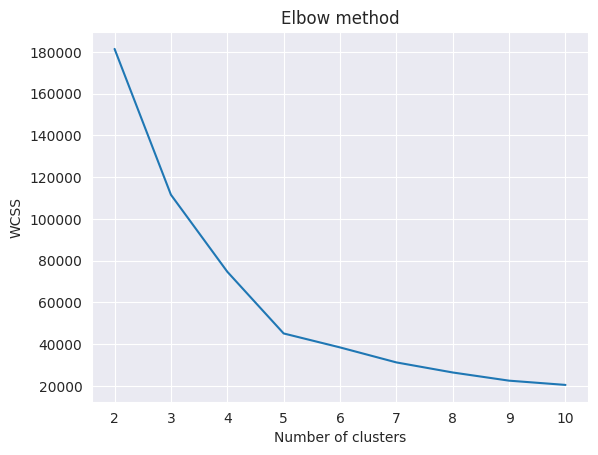

In [18]:
# Let's see how many clusters should we choose
elbow_method(
    X=data_pca,
    min_cluster_range=2,
    max_cluster_range=10
)

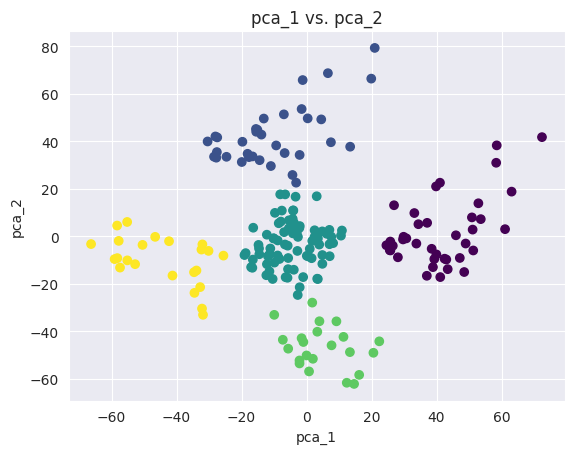

In [19]:
# Make an instance of K-Means
kmeans: KMeans = KMeans(n_clusters=answer)
clusters: np.ndarray = kmeans.fit_predict(data_pca_df[["pca_1", "pca_2"]])
data_pca_df["cluster"] = clusters

# Let's visualize it more clearly
plot_scatter(
    x="pca_1",
    y="pca_2",
    data=data_pca_df,
    c=data_pca_df["cluster"],
    cmap="viridis"
)

However, the cost for this technique is **lost of information**.

In [20]:
# Use other data
X = data_2d.drop("cluster", axis=1)

# Using PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X.values)

# Inverse transform using PCA
X_inv: np.ndarray = pca.inverse_transform(X_pca)

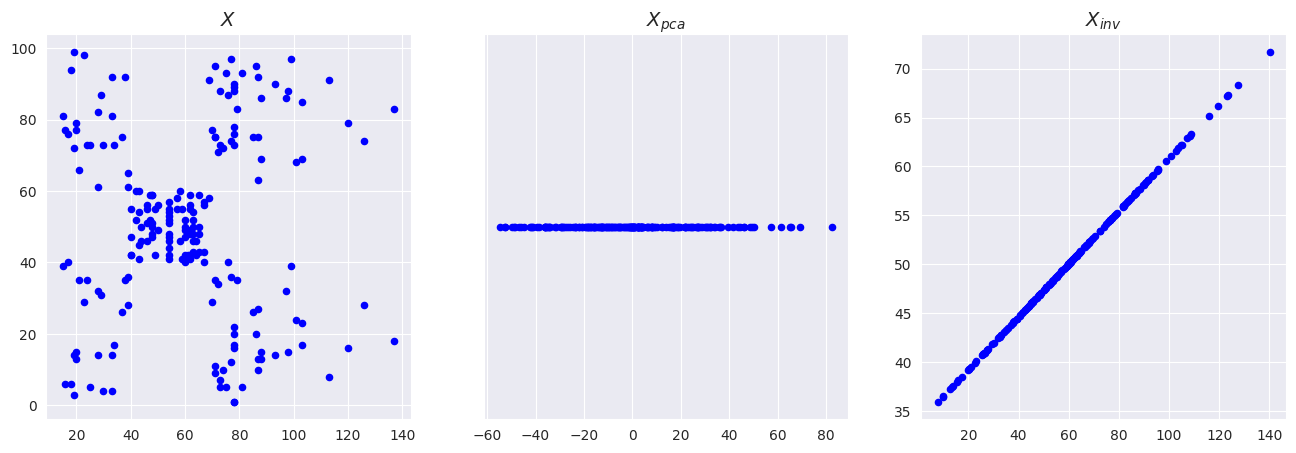

In [21]:
# Plot the difference of 3 things
plt.figure(figsize=(16, 5))

plt.subplot(131)
plt.scatter(X.values[:, 0], X.values[:, 1], s=20, c='b');
plt.title("$X$", fontsize=14)

plt.subplot(132)
plt.scatter(X_pca, np.zeros_like(X_pca), s=20, c='b');
plt.yticks([])
plt.title("$X_{pca}$", fontsize=14);

plt.subplot(133)
plt.scatter(X_inv[:, 0], X_inv[:, 1], s=20, c='b')
plt.title("$X_{inv}$", fontsize=14);

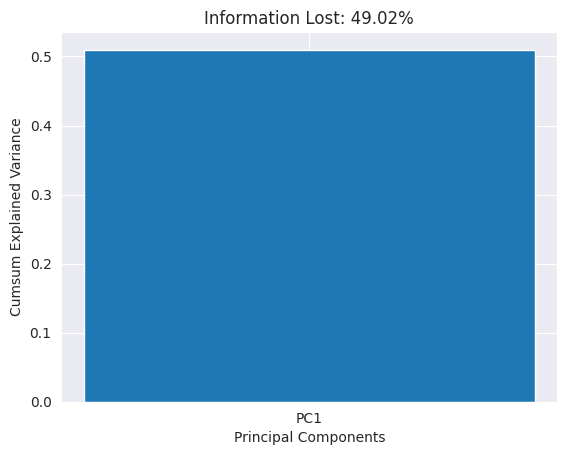

In [22]:
# Define x-axis and y-axis
x = [f"PC{i}" for i in range(1, pca.n_components_+1)]
y = pca.explained_variance_ratio_.cumsum()

# Plot Cumulated of Explained Variance
plt.bar(x, y)
plt.xlabel('Principal Components')
plt.ylabel('Cumsum Explained Variance')
plt.title(f"Information Lost: {100 - round(y[-1]*100, 2)}%")
plt.show()

If you need more explanation about this, **let this to be kak Dian's assessment**.

### Congratulations !!

Probably, this is the last question. **How do we know, that number of clusters I define is absolutely correct?**

**Question 3.** Is there any way to know what is the optimal and absolute number of clusters, such as advanced elbow-method?

In [23]:
# Give your answer by using 'True' or 'False'
answer: Union[str, bool] = False

check_answer_3(answer)

Wrong answer:

Because clustering is unsupervised learning, we always don't know the right answer for this.
Human intervention is always the best solution.


Before we end this, why don't we compare the result with **DBSCAN**

### DBSCAN

In [24]:
from sklearn.cluster import DBSCAN

# Make an instance of DBSCAN
dbscan: DBSCAN = DBSCAN(eps=10, min_samples=5)
dbscan.fit(X=X)

# Add clusters into new column
clustered_dbscan: pd.DataFrame = X.copy()
clustered_dbscan["cluster"] = dbscan.labels_

In [25]:
# Show 'clustered_dbscan' rows look like
clustered_dbscan

,Annual Income (k$),Spending Score (1-100),cluster
0,15,39,0
1,15,81,0
2,16,6,1
3,16,77,0
4,17,40,0
...,...,...,...
195,120,79,-1
196,126,28,-1
197,126,74,-1
198,137,18,-1


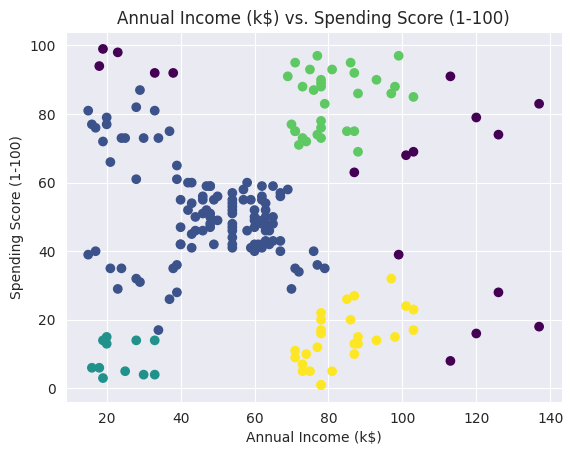

In [26]:
plot_scatter(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    data=clustered_dbscan,
    c=clustered_dbscan["cluster"],
    cmap="viridis"
)

The result is not that bad, right? **However, KMeans is still winning over DBSCAN..**